# Dogs vs Cats and the power of transfer learning

The goal of this notebook is to classify whether images contain either a dog or a cat. We will use "transfer learning" 


The data for this competition can be found [here](https://www.kaggle.com/c/dogs-vs-cats).



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle competitions download -d  dogs-vs-cats -p PATH` <br/>

In [3]:
PATH = Path("/data2/yinterian/dogscats/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/dogscats/train-250'),
 PosixPath('/data2/yinterian/dogscats/model.pth'),
 PosixPath('/data2/yinterian/dogscats/valid-250'),
 PosixPath('/data2/yinterian/dogscats/mode_tmp.pth'),
 PosixPath('/data2/yinterian/dogscats/valid_250'),
 PosixPath('/data2/yinterian/dogscats/valid'),
 PosixPath('/data2/yinterian/dogscats/test1'),
 PosixPath('/data2/yinterian/dogscats/sample'),
 PosixPath('/data2/yinterian/dogscats/train'),
 PosixPath('/data2/yinterian/dogscats/models'),
 PosixPath('/data2/yinterian/dogscats/train_250')]

In [4]:
! ls /data2/yinterian/dogscats/train

cats  dogs


In [5]:
! ls /data2/yinterian/dogscats/train/cats | head

cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
cat.10004.jpg
cat.10005.jpg
cat.10006.jpg
cat.10007.jpg
cat.10008.jpg
ls: write error: Broken pipe


In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

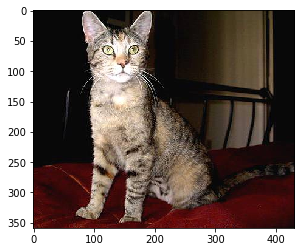

In [7]:
path = PATH/"train/cats/cat.10000.jpg"
im = read_image(path)
plt.imshow(im)

In [8]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(359, 431, 3)

In [9]:
# let's look at the typical size of these images
path = PATH/"train/cats"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]
dims[:10]

[(411, 500, 3),
 (374, 500, 3),
 (374, 500, 3),
 (479, 400, 3),
 (349, 400, 3),
 (374, 498, 3),
 (374, 500, 3),
 (431, 288, 3),
 (317, 336, 3),
 (399, 310, 3)]

## Saving a resized dataset
This step will save you a lot of time. Resizing is expensive. You want to do it once!

In [10]:
# make a new dirs
(PATH/"train_250/cats").mkdir(parents=True, exist_ok=True)
(PATH/"train_250/dogs").mkdir(parents=True, exist_ok=True)
(PATH/"valid_250/cats").mkdir(parents=True, exist_ok=True)
(PATH/"valid_250/dogs").mkdir(parents=True, exist_ok=True)

In [11]:
def center_crop_square(im):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(center_crop_square(im), (sz, sz))

In [12]:
from os import listdir
from os.path import join
def resize_all_images(new_path=PATH/"valid_250/"):
    orig_path = Path(str(new_path).split("_")[0])
    for cat in ["cats", "dogs"]:
        for f in (orig_path/cat).iterdir():
            img = get_a_crop(f)
            path = new_path/cat/f.name
            cv2.imwrite(str(path), img)

In [13]:
# Run this
#resize_all_images()
#resize_all_images(new_path=PATH/"train_250/")

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks.

In [14]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

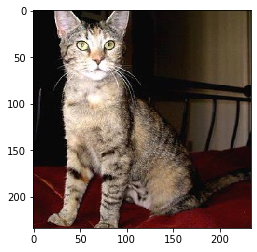

In [15]:
path = PATH/"train_250/cats/cat.10000.jpg"
im = read_image(path)
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

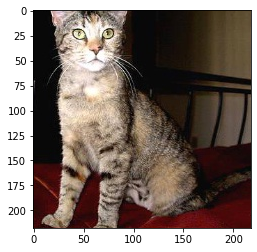

In [16]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im2 = random_crop(im)
plt.imshow(im2, cmap='gray')

### Random Rotation (-10, 10) 

-1.062082261633972


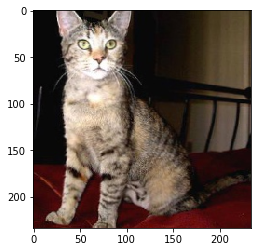

In [17]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

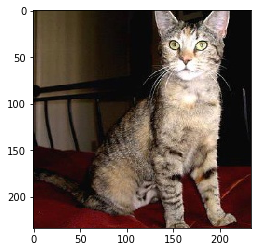

In [18]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Dataset

In [19]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [20]:
class DogsCatsDataset(Dataset):
    def __init__(self, path, transforms=False):
        self.path_to_images = path
        self.transforms = transforms
        self.cats_files = list((self.path_to_images/"cats").iterdir())
        self.dogs_files = list((self.path_to_images/"dogs").iterdir())
        self.files = self.cats_files + self.dogs_files
        # cats 1, dogs, 0
        self.y = np.concatenate((np.ones(len(self.cats_files), dtype=int),
                                np.zeros(len(self.dogs_files), dtype=int)), axis=0)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        path = str(self.files[idx]) 
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), self.y[idx]

In [21]:
train_ds = DogsCatsDataset(PATH/"train_250", transforms=True)
valid_ds = DogsCatsDataset(PATH/"valid_250")

In [22]:
len(train_ds)

23000

In [23]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [24]:
# run this multiple times to get different images
x, y = train_ds[0]
x.shape

(3, 234, 234)

In [25]:
x.shape,y

((3, 234, 234), 1)

## Model

In [26]:
resnet = models.resnet34(pretrained=True)
#resnet 

In [27]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [29]:
# this model just replaces the last layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)
        self.fc = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.size(0), -1) # flattening 
        x = self.fc(x)
        return x

In [30]:
model = Net().cuda()

In [31]:
x, y = next(iter(train_dl))

In [32]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([64, 3, 234, 234])

In [33]:
x_features = model.top_model(x)
x_features.shape

torch.Size([64, 512, 8, 8])

In [34]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [35]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [36]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [37]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(1)).item()

0.7202221155166626

In [38]:
y

tensor([0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')

## Learning rate finder

In [39]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [40]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr = lrs[0], wd = 0.0)
    for i in range(epochs):
        for x,y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [41]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

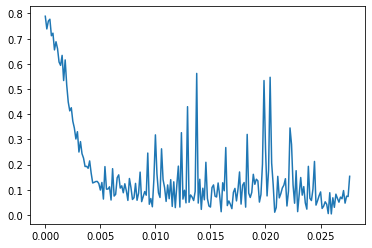

In [42]:
plt.plot(lrs[:200], losses[:200])
plt.show()

## Computing Accuracy

In [43]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().unsqueeze(1)
        out = model(x)
        pred = (out > 0.0).long()
        correct += pred.eq(y.data).sum().item()
        loss = F.binary_cross_entropy_with_logits(out, y.float())
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [44]:
val_metrics(model, valid_dl)

(0.8181063838005066, 0.471)

## Training with fixed learning rates

In [45]:
def train(model, epochs=5, learning_rate=0.01):
    optimizer = get_optimizer(model, lr = learning_rate, wd =0)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train loss %.3f val loss %.3f accuracy %.3f" % (sum_loss/total, val_loss, val_acc))

In [46]:
model = Net().cuda()
train(model)

train loss 0.080 val loss 0.042 accuracy 0.982
train loss 0.064 val loss 0.053 accuracy 0.983
train loss 0.064 val loss 0.094 accuracy 0.964
train loss 0.065 val loss 0.043 accuracy 0.987
train loss 0.059 val loss 0.038 accuracy 0.988


## Unfreezing layers

In [47]:
# save model
def save_model(m, p): 
    torch.save(m.state_dict(), p)
p = PATH/"model.pth"
save_model(model, p)

In [48]:
# load model
p = PATH/"model.pth"
model.load_state_dict(torch.load(p))

<All keys matched successfully>

In [49]:
val_metrics(model, valid_dl)

(0.03830617291294038, 0.9875)

In [50]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [51]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [52]:
unfreeze(model, 7)
unfreeze(model, 6)

In [53]:
# lower learning rate
train(model, epochs=5, learning_rate=0.0001)

train loss 0.056 val loss 0.033 accuracy 0.985
train loss 0.022 val loss 0.044 accuracy 0.984
train loss 0.017 val loss 0.029 accuracy 0.989
train loss 0.013 val loss 0.030 accuracy 0.988
train loss 0.012 val loss 0.027 accuracy 0.990


## Training with one-cycle and discriminative fine-tuning 
https://arxiv.org/pdf/1801.06146.pdf <br>
Leaving this for a future lecture.

## Testing time augmentation
Testing time augmentation is a technique that uses data aumentation at test time to improve the test predictions.

In [52]:
valid_ds = DogsCatsDataset(PATH/"valid_250")
valid_ds_trs = DogsCatsDataset(PATH/"valid_250", transforms=True)

In [53]:
batch_size = 64
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
valid_dl_trs = DataLoader(valid_ds_trs, batch_size=batch_size)

In [54]:
def val_arrays(model, dl):
    model.eval()
    preds = []
    ys = []
    for x, y in dl:
        x = x.cuda().float()
        out = model(x)
        pred = (out > 0.0).long()
        preds.append(pred.cpu().numpy())
        ys.append(y.unsqueeze(1).numpy())
    return np.vstack(preds), np.vstack(ys)

In [55]:
def TTAaccuracy(model, valid_dl, valid_dl_trs, ndls=4):
    preds, ys = val_arrays(model, valid_dl)
    pred_tuples = [val_arrays(model, valid_dl_trs) for i in range(ndls)]
    tr_preds = [p for p,y in pred_tuples]
    pp = np.hstack(tr_preds + [preds])
    final_prob = pp.mean(1)
    final_prediction = final_prob > 0.5
    return (final_prediction[:, None] == ys).sum()/len(final_prediction)

In [56]:
TTAaccuracy(model, valid_dl, valid_dl_trs)

0.9925

# References
This notebook is based on the implementation from fast.ai (with a few tweaks).